In this notebook we counstruct an LSTM network to construct prediction intervals of financial time seires using batches of length 7. For the loss function we still use non-differentiable convolution of PICP and PINRW, which couldn't be optimized by gradient solvers and may be optimized with PSO. While the model has total of 10,573 parameters we need a good initial approximation of swarm positions. In order to obtain one we first train the network with adam solver and MSE as the loss function as if we wanted to obtain point predictions, not intervals. Then we use PSO to find the weights for the goal convolution of criteria and predict intervals. Rely on the markdowns above the blocks

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [1]:
!pip show pandas || pip install pandas
!pip show sklearn || pip install -U scikit-learn
!pip show tensorflow || pip install -U tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten

Name: pandas
Version: 1.3.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /home/alexander/mambaforge/lib/python3.9/site-packages
Requires: numpy, python-dateutil, pytz
Required-by: bio-embeddings, bio-embeddings-deepblast, bio-embeddings-plus, dask-cuda, deepnog, goatools, pmdarima, seaborn, statsmodels
Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/alexander/mambaforge/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolo

2023-10-02 15:51:41.134932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 15:51:46.466004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-10-02 15:51:46.466027: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-02 15:51:56.912274: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared

In [2]:
!pip show pyswarms || pip install pyswarms


Name: pyswarms
Version: 1.3.0
Summary: A Python-based Particle Swarm Optimization (PSO) library.
Home-page: https://github.com/ljvmiranda921/pyswarms
Author: Lester James V. Miranda
Author-email: ljvmiranda@gmail.com
License: MIT license
Location: /home/alexander/mambaforge/lib/python3.9/site-packages
Requires: attrs, future, matplotlib, numpy, pyyaml, scipy, tqdm
Required-by: 


In [54]:
import pyswarms as ps
from pyswarms.single import GlobalBestPSO

In [55]:
import tensorflow as tf
import math
#tf.executing_eagerly()

In [56]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [57]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)



In [58]:
df.head()

,<DATE>,<CLOSE>
0,2003-03-03,352.24
1,2003-03-04,348.40
2,2003-03-05,357.65
3,2003-03-06,359.97
4,2003-03-07,354.87


In [59]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [60]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [61]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


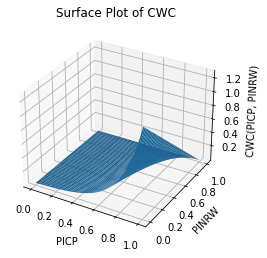

Maximum value of Z: 1.2776213132048868
Corresponding PICP and PINRW values: 0.999 0.0


In [99]:
#here we can investigate the etta and mu influence on the convolution surface shape

from mpl_toolkits.mplot3d import Axes3D

etta = 5
mu = 0.95

x = np.arange(0, 1, 0.001)
y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
Z = (1-Y) * (np.exp(etta * (X - mu)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('PICP')
ax.set_ylabel('PINRW')
ax.set_zlabel('CWC(PICP, PINRW)')
ax.set_title('Surface Plot of CWC')

plt.show()

max_value = np.max(Z)
max_index = np.unravel_index(np.argmax(Z), Z.shape)
max_x = X[max_index]
max_y = Y[max_index]

print("Maximum value of Z:", max_value)
print("Corresponding PICP and PINRW values:", max_x, max_y)

In [100]:
def CWC(y_true, y_pred, etta = 5, mu = 0.95):

    return (1-PINRW(y_pred)) * (tf.exp(etta * (tf.subtract(PICP(y_true, y_pred), mu))))


In [64]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
test = df[train_size:]

In [65]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df['<CLOSE>'].values.reshape(-1, 1))

In [66]:
train_scaled = df[:train_size]
test_scaled = df[train_size:]

In [67]:
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

In [68]:
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

In [69]:
X_train.shape

(4007, 1)

In [70]:
y_train.shape

(4007, 1)

In [71]:
X_test.shape

(1001, 1)

In [72]:
y_test.shape

(1001, 1)

Check that y is shifted 1 point ahead of X:

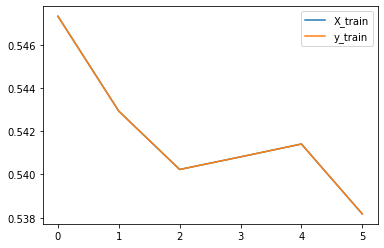

In [73]:
plt.plot(X_train[-6:], label='X_train')
plt.plot(y_train[-7:-1], label='y_train')
plt.legend()
plt.show()

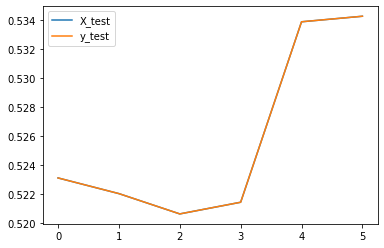

In [74]:
plt.plot(X_test[-6:], label='X_test')
plt.plot(y_test[-7:-1], label='y_test')
plt.legend()
plt.show()

In [75]:
def create_batches(data, batch_size):
    output = []
    for i in range(len(data)-batch_size+1):
        output.append(data[i:i+batch_size])
    return np.array(output)

batch_size = 1  # length of each batch

# Create batches
batches = create_batches(X_train, batch_size)

# Reshape to 3D
batches = batches.reshape((batches.shape[0], batches.shape[1], 1))

In [76]:
batches_test = create_batches(X_test, batch_size)
batches_test = batches_test.reshape((batches_test.shape[0], batches_test.shape[1], 1))

In [77]:
batches.shape

(4007, 1, 1)

In [78]:
# Define the model
model = Sequential([
    LSTM(units=50),
    Dense(units=3),
    Dense(units=3),
    Dense(units=2)
])

In [79]:
# Build the model
input_shape = batches.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

def evaluate_nn(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    for weights in W:
        model.set_weights(set_shape(weights,shape))
        predictions = model.predict(X_train)
        solution_fitness = 1-CWC(Y_train, predictions).numpy() / max_value
        results.append(solution_fitness)
    return results

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 2)                 8         
                                                                 
Total params: 10,573
Trainable params: 10,573
Non-trainable params: 0
_________________________________________________________________


First find the initial approximation of parameters with MSE and adam solver:

In [81]:
model.compile(loss = "mse", optimizer = 'adam')

In [82]:
model.fit(batches, y_train[batch_size-1:], batch_size=batch_size, epochs=100)

Epoch 1/100
4007/4007 [==============================] - 7s 1ms/step - loss: 0.0014
Epoch 2/100
4007/4007 [==============================] - 5s 1ms/step - loss: 5.9749e-05
Epoch 3/100
4007/4007 [==============================] - 5s 1ms/step - loss: 5.8713e-05
Epoch 4/100
4007/4007 [==============================] - 5s 1ms/step - loss: 6.1728e-05
Epoch 5/100
4007/4007 [==============================] - 5s 1ms/step - loss: 5.7278e-05
Epoch 6/100
4007/4007 [==============================] - 6s 1ms/step - loss: 5.7516e-05
Epoch 7/100
4007/4007 [==============================] - 6s 1ms/step - loss: 5.7535e-05
Epoch 8/100
4007/4007 [==============================] - 6s 2ms/step - loss: 5.7144e-05
Epoch 9/100
4007/4007 [==============================] - 6s 1ms/step - loss: 5.4781e-05
Epoch 10/100
4007/4007 [==============================] - 6s 1ms/step - loss: 5.5055e-05
Epoch 11/100
4007/4007 [==============================] - 6s 1ms/step - loss: 5.6264e-05
Epoch 12/100
4007/4007 [==========

In [83]:
def unpack_weights(model):
    # Get the weights from the model
    weights = model.get_weights()

    # Initialize an empty list to store the flattened weights
    flattened_weights = []

    # Loop over each weight array in the list of weights
    for weight_array in weights:
        # Flatten the weight array and append it to the list
        flattened_weights.append(weight_array.flatten())

    # Concatenate all the flattened weight arrays into a single numpy array
    unpacked_weights = np.concatenate(flattened_weights)

    return unpacked_weights

In [84]:
initial_positions = unpack_weights(model)

Check whether we got as many unpacked weights as model has parameters

In [85]:
initial_positions.shape[0] == model.count_params()

True

In [86]:
import random


def evaluate_picp_pinrw(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    i = 1
    for iteration in W:
        print("=== Iteration number ===", i)
        #if i == 358:
        #    break 
        i = i + 1
            #random_number = random.randint(0, 29)
        for weights in iteration:
            #weights = iteration[random_number]
            model.set_weights(set_shape(weights,shape))
            predictions = model.predict(X_train)
            picp = PICP(Y_train, predictions)
            pinrw = PINRW(predictions)
            results.append([picp.numpy(), pinrw.numpy()])
    return results

In [87]:
shape = get_shape(model)

In [88]:
n_particles = 60 #number of particles of PSO

In [105]:
# Generate the random initial positions for all n_particles points
initial_positions1 = np.random.uniform(-0.01, 0.01, size=(n_particles, model.count_params()))

In [106]:
initial_positions1 += initial_positions

In [107]:
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = GlobalBestPSO(n_particles= n_particles, dimensions=model.count_params(), init_pos = initial_positions1,
                          options=options)#, bounds=bounds)#, velocity_clamp = vel_bounds)

Execute if you wish to perform the new search with PSO

In [108]:
#tf.executing_eagerly()

In [116]:
cost, pos = optimizer.optimize(evaluate_nn, 1, X_train=batches, Y_train=y_train,shape=shape)

2023-10-02 20:10:26,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best:   0%|                                          |0/1

126/126 [==============================] - 3s 23ms/step


pyswarms.single.global_best: 100%|████████████████████████|1/1, best_cost=0.0587
2023-10-02 20:13:13,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.058665589852044286, best pos: [0.52842945 0.3555709  0.22559542 ... 0.79667752 0.18626315 0.24458511]


In [ ]:
pos.shape

In [117]:
df = pd.DataFrame(pos)
df.to_csv('best_pos.csv', index=False)

In [114]:
#Execute to read best_pos from file

df = pd.read_csv('best_pos.csv')
pos = df.to_numpy()

In [118]:
model.set_weights(set_shape(pos,shape))

Execute if you wish to save the search сost history in a local file:

In [46]:
import pandas as pd

cost_history = optimizer.cost_history

df = pd.DataFrame(cost_history)
df.to_csv('cost_history.csv', index=False)

Execute if you wish to save the search positions history in a local file:

In [47]:
pos_history = optimizer.pos_history

# Reshape pos_history to a 2D array
pos_history_2d = np.array(pos_history).reshape((-1, len(pos_history[0])))

df = pd.DataFrame(pos_history_2d)
df.to_csv('pos_history.csv', index=False)



Execute if you wish to read the precomputed positions history from a local file:

In [ ]:
# Read the pos_history.csv file
df = pd.read_csv('pos_history.csv')

# Convert the DataFrame back to a 2D array
pos_history_2d = df.to_numpy()

# Reshape the 2D array to the desired shape
pos_history = pos_history_2d.reshape((1300, 30, 26))


<H1> Predictions section:

In [123]:
y_pred = model.predict(batches_test)
y_pred = scaler.inverse_transform(y_pred)

32/32 [==============================] - 1s 17ms/step


In [124]:
y_test_plot = scaler.inverse_transform(y_test)

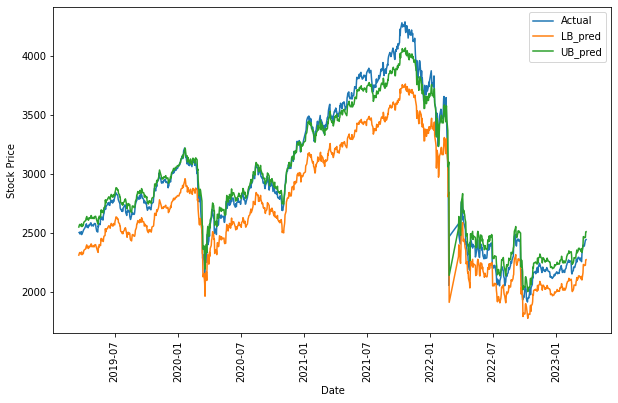

In [125]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(test['<DATE>'][2:], y_test_plot[1:], label='Actual')

ax.plot(test['<DATE>'][batch_size:], y_pred[:,0], label='LB_pred')
ax.plot(test['<DATE>'][batch_size:], y_pred[:,1], label='UB_pred')


ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()

2023-10-02 20:15:37,375 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-02 20:15:37,377 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-02 20:15:37,379 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-02 20:15:37,382 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-02 20:15:37,

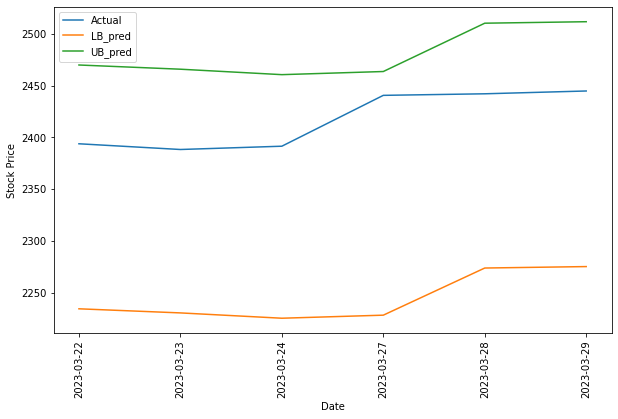

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))

last_dates = ('2023-03-22','2023-03-23','2023-03-24','2023-03-27','2023-03-28','2023-03-29')

ax.plot(last_dates, y_test_plot[-6:], label='Actual')

ax.plot(last_dates, y_pred[-6:,0], label='LB_pred')
ax.plot(last_dates, y_pred[-6:,1], label='UB_pred')

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()